In [12]:
from ase.build import nanotube
from ase.visualize import view
#cnt = nanotube(6, 0, length=4)
#cnt.rotate([1,0,0], [0,0,1])
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp
from ase.build import make_supercell

In [75]:
def Gaussian2D(x, y, A, xc, yc, sigma):
    return A*np.exp(
        -(
            (x-xc)**2 + 
            (y-yc)**2
        )/(2*sigma**2))

def Gaussian2DCupy(x, y, A, xc, yc, sigma):
    return A*cp.exp(
        -(
            (x-xc)**2 + 
            (y-yc)**2
        )/(2*sigma**2))

def SympyGaussian2D(x, y, A, xc, yc, sigma):
    return A*sp.exp(
        -(
            (x-xc)**2 + 
            (y-yc)**2
        )/(2*sigma**2))

def rotation_matrix(deg):
    c = np.cos(np.deg2rad(deg))
    s = np.sin(np.deg2rad(deg))
    return np.array([[c, -s],[s, c]])

def rotation_matrix_cupy(deg):
    c = cp.cos(cp.deg2rad(deg))
    s = cp.sin(cp.deg2rad(deg))
    return cp.array([cp.array([c, -s]), cp.array([s, c])])

def meshgridCupy(x, y):
    X = np.tile(x[:, None], len(y)).T
    Y = np.tile(y[:, None], len(x))

def ac_noise(shape, strength=0.5, dwelltime=1e-6):
    ac_freq = 50 #hz
    noise = np.zeros((2,) + shape)
    noise[0] = strength * np.sin(
        2*dwelltime / (1/ac_freq) * np.arange(np.prod(shape)) * np.pi
    ).reshape(shape)
    return noise
    
def add_drift(Xshape, drift_vector = [1,0], strength=1e-4):
    vector = cp.array(drift_vector)
    probe_indices = cp.arange(cp.prod(cp.array(Xshape))).reshape(Xshape)
    return (strength * vector * probe_indices.T[..., None]).T

class ImageModel:
    power = 1.8

    def __init__(
        self, 
        atoms=None, positions=None, numbers=None,
        pixel_size=0.1, sigma=0.2, power=1.8, 
        drift_strength = 0, drift_vector=[1,0], centre_drift=True,
        scan_rotation = 0, square = False, vacuum=5.0):
        
        if atoms:
            self.atom_positions = atoms.positions[:,:2]
            self.atom_numbers = atoms.numbers
        else:
            self.atom_positions = positions
            self.atom_numbers = numbers
        self.number_of_atoms = len(self.atom_numbers)
        self.pixel_size = pixel_size
        self.sigma = sigma
        self.drift_strength = drift_strength
        self.drift_vector = drift_vector
        self.centre_drift = centre_drift
        self.scan_rotation = scan_rotation
        self.square = square
        self.margin = vacuum
        
        self.create_probe_positions()
        self.create_probe_positions_cupy()
        self.create_parameters()
        self.create_parameters_cupy()
        
    def init_sympy(self):
        xy = sp.symbols('x y')
        parameters = sp.symbols('A xc yc sigma', cls=sp.IndexedBase)
        i,n = sp.symbols("i n", integer=True)
        self.symbols = xy + parameters + (n,)
        A, xc, yc, sigma = parameters
        
        Gauss = SympyGaussian2D(*xy, A[i], xc[i], yc[i], sigma[i])
        model = sp.Sum(Gauss, (i,0,n-1))
        self.model = model

    def create_probe_positions(self):
        xlow, ylow = self.atom_positions.min(0) - self.margin
        xhigh, yhigh = self.atom_positions.max(0) + self.margin
        scale = (xhigh - xlow)/100

        if self.square:
            xlow = ylow = min(xlow, ylow)
            xhigh = yhigh = max(xhigh, yhigh)
        xrange = np.arange(xlow, xhigh+scale, self.pixel_size)
        yrange = np.arange(ylow, yhigh+scale, self.pixel_size)
        XY = np.stack(np.meshgrid(xrange, yrange))
        
        if self.scan_rotation:
            mean = XY.mean(axis=(-1,-2))[:, None]
            self.probe_positions = (
                rotation_matrix(self.scan_rotation) @ (
                    XY.reshape((2, -1)) - mean) + mean
            ).reshape((2, *XY.shape[1:]))
        else:
            self.probe_positions = XY
    
    def create_probe_positions_cupy(self):
        xlow, ylow = self.atom_positions.min(0) - self.margin
        xhigh, yhigh = self.atom_positions.max(0) + self.margin
        scale = (xhigh - xlow)/100

        if self.square:
            xlow = ylow = min(xlow, ylow)
            xhigh = yhigh = max(xhigh, yhigh)
        xrange = cp.arange(xlow, xhigh+scale, self.pixel_size)
        yrange = cp.arange(ylow, yhigh+scale, self.pixel_size)
        XY = cp.stack(cp.meshgrid(xrange, yrange))
        
        if self.drift_strength:
            drift = add_drift(XY.shape[1:], self.drift_vector, self.drift_strength)
            XY += drift
            
            if self.centre_drift:
                driftx, drifty = drift
                offsetx = driftx.max() if driftx.max() > -driftx.min() else driftx.min()
                offsety = drifty.max() if drifty.max() > -drifty.min() else drifty.min()
                XY -= cp.array([offsetx, offsety])[:, None, None] / 2
        
        if self.scan_rotation:
            mean = XY.mean(axis=(-1,-2))[:, None]
            self.probe_positions_cupy = (
                rotation_matrix_cupy(self.scan_rotation) @ (
                    XY.reshape((2, -1)) - mean) + mean
            ).reshape((2, *XY.shape[1:]))
        else:
            self.probe_positions_cupy = XY
    
    def create_parameters(self):
        xc, yc = self.atom_positions.T
        A = self.atom_numbers ** self.power
        sigma = np.ones(self.number_of_atoms) * self.sigma
        self.parameters = np.array([A, xc, yc, sigma])
        
    def create_parameters_cupy(self):
        self.parameters_cupy = cp.array(self.parameters)
        
    def generate_lambdify(self):
        self.init_sympy()
        func = sp.lambdify(self.symbols, self.model, modules = 'numpy')
        self.func = func
        return func(*self.probe_positions, *self.parameters, self.number_of_atoms)
    
    def generate_lambdify_cupy(self):
        self.init_sympy()
        func = sp.lambdify(self.symbols, self.model, modules = 'cupy')
        self.func_cupy = func
        return func(*self.probe_positions_cupy, *self.parameters_cupy, self.number_of_atoms)
    
    def generate_cupy(self):
        X, Y = self.probe_positions_cupy
        img = cp.zeros(X.shape)
        #As, XC, YC, SIGMA = self.parameters_cupy
        for parameters in self.parameters_cupy.T:
            img += Gaussian2DCupy(X, Y, *parameters)
        return img
 
    def generate_cupy_ram(self):
        X, Y = self.probe_positions_cupy
        img = cp.sum(Gaussian2DCupy(X[..., None], Y[..., None], *self.parameters_cupy), -1)
        return img
    
    def generate_numpy(self):
        img = np.zeros(self.probe_positions[0].shape)
        for parameters in self.parameters.T:
            gauss = Gaussian2D(*self.probe_positions, *parameters)
            img += gauss
        return img
    

In [76]:
from ase.io import read
atoms = read(r"C:\Users\thomasaar\Downloads\imeall-master\imeall\examples\boundary_interstitials\0013687130_v6bxv2_tv0.1bxv0.0_d1.8z_traj.xyz")
atoms = make_supercell(atoms, np.diag((1,2,1)))
mask = atoms.positions[:,2] > 35
del atoms[mask]

atoms[1716].number = 60
atoms.rotate((1,0,0), (0,0,1), rotate_cell=True)
atoms.center(about=0.)

In [77]:
m = ImageModel(atoms, sigma=0.4)

m.probe_positions_cupy += cp.array(
    ac_noise(
        m.probe_positions.shape[1:],
    ))#line_noise #cp.asarray(drift)# + noise

img = cp.asnumpy(m.generate_cupy())

In [78]:
def add_line_noise(XYshape, strength = 0.3):
    line_noise = cp.zeros(XYshape)
    line_noise[0] += 0.3*(2*cp.random.random((XYshape[1])) - 1)[:, None]
    return line_noise

In [84]:
import numpy as np
from PIL.Image import fromarray

from ase.io import read
atoms = read(r"C:\Users\thomasaar\Downloads\imeall-master\imeall\examples\boundary_interstitials\0013687130_v6bxv2_tv0.1bxv0.0_d1.8z_traj.xyz")
atoms = make_supercell(atoms, np.diag((1,2,1)))
mask = atoms.positions[:,2] > 35
del atoms[mask]

atoms[1716].number = 60
atoms.rotate((1,0,0), (0,0,1), rotate_cell=True)
atoms.center(about=0.)

for theta in [0, 30, 60, 90, 120, 150, 180]:
    m = ImageModel(atoms, sigma=0.4, scan_rotation=theta, drift_strength=0e-4, vacuum=10.)
    m.probe_positions_cupy += add_line_noise(m.probe_positions.shape)
    img = m.generate_cupy()
    img /= img.max() / 255
    img = cp.asnumpy(img.astype('uint8'))
    fromarray(img).save(f'grainboundary_{theta}.png')    

In [86]:
np.version.version

'1.19.4'

In [88]:
cp.__version__

'8.2.0'

In [ ]:
cp.prod(cp.array([1,2,]))

In [53]:
cp.prod(cp.array([1,2,]))

array(2)

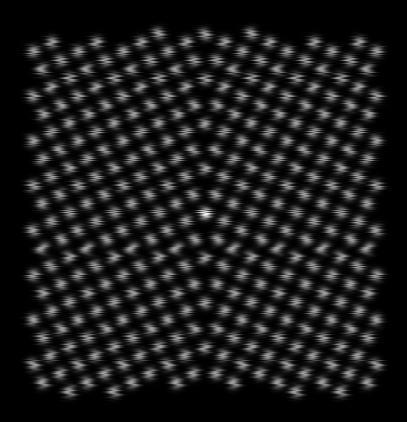

In [8]:
PIL.__version__

'8.0.1'

In [146]:

def add_drift(Xshape, drift_vector = [1,0], strength=1e-4):
    vector = cp.array(vector)
    probe_indices = np.arange(np.prod(Xshape)).reshape(Xshape)
    return (strength * vector * probe_indices.T[..., None]).T
    
    
drift_vector = np.array([1,0]) # apply drift before scan rotation
scale = 0.0001
probe_indices = np.arange(np.prod(m.probe_positions.shape[1:])).reshape(m.probe_positions.shape[1:])
drift = (scale * drift_vector * probe_indices.T[..., None]).T

random_noise = (2*cp.random.random(m.probe_positions_cupy.shape)-1) * 0.1

line_noise = cp.zeros(m.probe_positions.shape)
line_noise[0] += 0.3*(2*cp.random.random((m.probe_positions.shape[1])) - 1)[:, None]

m.probe_positions_cupy += cp.array(
    ac_noise(
        m.probe_positions.shape[1:],
    ))#line_noise #cp.asarray(drift)# + noise

img = cp.asnumpy(m.generate_lambdify_cupy())


In [138]:
%matplotlib widget

In [139]:
plt.figure(figsize=(8,5))
plt.imshow(img);
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [64]:
img.shape

(97, 247)

In [ ]:
# img1 = m.generate_cupy()
# img2 = m.generate_cupy_ram()
# img3 = m.generate_numpy()
# img4 = m.generate_numpy_ram()
# img5 = m.generate_lambdify()
# img6 = m.generate_lambdify_cupy()
# img7 = m.generate_crop()
# img8 = m.generate_crop_cupy()

# imgs = [cp.asnumpy(img1), cp.asnumpy(img2), img3, img4, img5, cp.asnumpy(img6), img7, cp.asnumpy(img8), ]

In [14]:
atoms = nanotube(5, 3, length=4)
atoms.rotate((1,0,0), (0,0,1), rotate_cell=True)
atoms.center(about=0.)

m = ImageModel(atoms, pixel_size=0.1)


In [15]:
%time img1 = m.generate_cupy()
%time img2 = m.generate_cupy_ram()

Wall time: 138 ms
Wall time: 1 ms


In [ ]:
1

In [19]:
1

1

In [18]:
#%timeit img2 = m.generate_cupy_ram()

In [11]:
%time img1 = m.generate_cupy()
%time img2 = m.generate_cupy_ram()

Wall time: 134 ms
Wall time: 0 ns


In [9]:
%time img1 = m.generate_cupy()
%time img2 = m.generate_cupy_ram()

%time img3 = m.generate_numpy()
%time img4 = m.generate_numpy_ram()

%time img5 = m.generate_lambdify()
%time img6 = m.generate_lambdify_cupy()

%time img7 = m.generate_crop()
%time img8 = m.generate_crop_cupy()

%time img9 = m.generate_crop_cupy2()

Wall time: 130 ms
Wall time: 0 ns
Wall time: 5.89 s
Wall time: 6.71 s
Wall time: 6.46 s
Wall time: 171 ms
Wall time: 6.18 s
Wall time: 874 ms
Wall time: 675 ms


In [ ]:
probe_positions_shape = np.shape(m.probe_positions)
noise = (2*np.random.random(probe_positions_shape)-1) * 0.1



In [ ]:
%time img7 = m.generate_crop()


In [ ]:
# #%time img1 = m.generate_cupy()
# #%time img2 = m.generate_cupy_ram()

# %time img3 = m.generate_numpy()
# %time img4 = m.generate_numpy_ram()

# %time img5 = m.generate_lambdify()
# %time img6 = m.generate_lambdify_cupy()

# %time img7 = m.generate_crop()
# %time img8 = m.generate_crop_cupy()

In [ ]:
fig, AX = plt.subplots(nrows=len(imgs))
for i, ax in enumerate(AX):
    ax.imshow(imgs[i])

In [ ]:
type(img6)

In [ ]:
m.parameters[3]

In [ ]:
for img in imgs[1:]:
    print(np.abs(img - imgs[0]).sum())

In [ ]:
%matplotlib widget

In [ ]:
pixel_size = 0.1
scan_rotation = 0
square = True

xlow, ylow, zlow = atoms.positions.min(0) - 3
xhigh, yhigh, zhigh = atoms.positions.max(0) + 3
scale = (xhigh - xlow)/100

if square:
    xlow = ylow = min(xlow, ylow)
    xhigh = yhigh = max(xhigh, yhigh)
xrange = np.arange(xlow, xhigh+scale, pixel_size)
yrange = np.arange(ylow, yhigh+scale, pixel_size)
X, Y = np.meshgrid(xrange, yrange)
mean = np.array([X.mean(), Y.mean()])[:, None]
X, Y = (
    rotation_matrix(scan_rotation) @ (
        np.array([X.flatten(), Y.flatten()]) - mean 
    ) + mean).reshape((2, *X.shape))



In [ ]:
m = ImageModel(atoms, 0.01)
img = m.generate_cupy()

In [ ]:
from PIL import Image
im = Image.fromarray(img.astype("uint16"))
im.save(f'nanotube.tif')

In [ ]:
plt.figure(figsize = (20,5))
plt.imshow(img)

In [ ]:
@jit(nopython=True, parallel=True)
def numpyloop(X, Y, numbers, positions):
    img = np.zeros(X.shape)
    for number, position in zip(numbers, positions):
        gauss = Gaussian2D(X, Y, 5, position[0], position[1], 0.2)
        img += gauss

In [ ]:
%%timeit
numpyloop(X, Y, atoms.numbers, atoms.positions)

In [ ]:
def cupyloop(atoms):
    img = cp.zeros(X.shape)
    for number, position in zip(atoms.numbers, atoms.positions):
        gauss = Gaussian2DCupy(X, Y, number**1.8, position[0], position[1], 0.2)
        img += gauss
    return cp.asnumpy(img)

In [ ]:
X2 = cp.array(X)
Y2 = cp.array(Y)
numbers, positions = cp.array(atoms.numbers), cp.array(atoms.positions)


In [ ]:
%%time
img = cupyloop(X2, Y2, numbers, positions)

In [ ]:
img.shape

In [ ]:
plt.figure()
plt.imshow(img)

In [ ]:
m = ImageModel(atoms, 0.1, 0, True)

In [ ]:
img2 = m.generate()


In [ ]:
from ase.build import stack, make_supercell
a = make_supercell(atoms, np.diag([3,3,3]))

In [ ]:
view(a)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(img)

In [ ]:
img /= img.max()
img *= 200 
img += np.random.poisson(img)
plt.figure()
plt.imshow(img)
im = Image.fromarray(img.astype("uint16"))
im.save(f'grains.tif')

In [ ]:
for i, rot in (enumerate([0, 90, 180, 270])):
    m.scan_rotation = rot
    img = m.generate()
    #img = np.rot90(img, i, (1,0))
    img /= img.max()
    img *= 200 
    img += np.random.poisson(img)
    plt.figure()
    plt.imshow(img)
    im = Image.fromarray(img.astype("uint16"))
    im.save(f'Rot2_{i}.tif')

In [ ]:
from PIL import Image

In [ ]:
plt.figure()

plt.imshow(img)


In [ ]:

def rot(deg):
    rm = rotation_matrix(deg)
    x,y = m.positions()
    return np.einsum('ji, mni -> jmn', rm, np.dstack([x, y]))

In [ ]:
r = rot(20)

In [ ]:
x,y = 

In [ ]:
plt.figure()
x, y = m.positions()
plt.scatter(x,y)


mean = np.array([x.mean(), y.mean()])[:, None]
print(mean)
x, y = (rotation_matrix(20) @ (np.array([x.flatten(), y.flatten()]) - mean ) + mean).reshape((2, *x.shape))
plt.scatter(x,y)

#x, y = r
#plt.scatter(x,y)

In [ ]:
pixel_size = 1
xlow, ylow, zlow = atoms.positions.min(0) - 3
xhigh, yhigh, zhigh = atoms.positions.max(0) + 3
scale = (xhigh - xlow)/100

xrange = np.arange(xlow, xhigh+pixel_size, pixel_size)
yrange = np.arange(ylow, yhigh+pixel_size, pixel_size)

In [ ]:
xrange

In [ ]:
xrange = np.array([1,2,3,4])
np.tile(xrange, 4)

In [ ]:
xrange = np.random.random(500)
yrange = np.random.random(300)

In [ ]:
%%timeit



In [ ]:
%%timeit
X2, Y2 = np.meshgrid(xrange,yrange)

In [ ]:
np.testing.assert_almost_equal(Y, Y2)

In [ ]:
X.shape

In [ ]:
Y.shape

In [ ]:
X.shape

In [ ]:
%%timeit
x1, y1 = np.meshgrid(xrange, yrange)
x1, y1 = x1.flatten(), y1.flatten()

In [ ]:
print(x1.flatten())
print(y1.flatten())

In [ ]:
%%timeit
x = xrange.copy()
np.tile(x[:, None], 4).flatten()

In [ ]:
x,y = m.positions()

def func(deg, x, y):
    x, y = (rotation_matrix(deg) @ np.array([x.flatten(), y.flatten()])).reshape((2, *x.shape))
    return (x,y)

def rot(deg, x, y):
    rm = rotation_matrix(deg)
    return np.einsum('ji, mni -> jmn', rm, np.dstack([x, y]))

In [ ]:
%timeit func(20, x.copy(), y.copy())
%timeit rot(20, x.copy(), y.copy())

In [ ]:
def DoRotation(xspan, yspan, RotRad=0):
    """Generate a meshgrid and rotate it by RotRad radians."""

    # Clockwise, 2D rotation matrix
    RotMatrix = np.array([[np.cos(RotRad),  np.sin(RotRad)],
                          [-np.sin(RotRad), np.cos(RotRad)]])

    x, y = np.meshgrid(xspan, yspan)
    return np.einsum('ji, mni -> jmn', RotMatrix, np.dstack([x, y]))

In [ ]:
m = ImageModel(atoms)

In [ ]:
img = m.generate()

In [ ]:
plt.figure()
plt.imshow(img)

In [ ]:
rotation_matrix(20) @ (x, y)
Z = np.array([X.flatten(), Y.flatten()])

In [ ]:
Z2 = rotation_matrix(20) @ Z

In [ ]:
X2, Y2 = Z2
#X2 = X2.reshape(X.shape)
#Y2 = Y2.reshape(X.shape)

In [ ]:
plt.figure()
plt.hist2d(X.flatten(), Y.flatten(), 100, range=((-10, 30), (-10, 30)))

In [ ]:
plt.figure()
plt.hist2d(X2, Y2, 100, range=((-10, 30), (-10, 30)))

In [ ]:
plt.figure()
plt.scatter(X, Y)
plt.scatter(X2, Y2)
plt.axis('equal')

In [ ]:
model = ImageModel(cell)
for scale in [0.12]:
    model.pixel_size = scale
    img = model.generate()
    plt.figure()
    plt.imshow(img)

In [ ]:
import atomap.api as am

In [ ]:
import hyperspy.api as hs

In [ ]:
s = hs.signals.Signal2D(img)

In [ ]:
s_peaks = am.get_feature_separation(s, separation_range=(2, 20))

In [ ]:
s_peaks.plot()

In [ ]:
atom_positions = am.get_atom_positions(s, separation=5)

In [ ]:
sublattice = am.Sublattice(atom_positions, image=s.data)

In [ ]:
import numpy as np
np.array(data)

In [ ]:
sublattice.find_nearest_neighbors()
sublattice.refine_atom_positions_using_center_of_mass()
sublattice.refine_atom_positions_using_2d_gaussian()

In [ ]:
 points_x, points_y = sublattice.atom_positions.T

In [ ]:
from atomap.tools import remove_integrated_edge_cells

integrated_intensity, intensity_record, point_record = am.integrate(s, points_x, points_y)
ii, ir, pr = remove_integrated_edge_cells(integrated_intensity, intensity_record, point_record, edge_pixels=1)

In [ ]:
pr.plot()

In [ ]:
def probe_positions(model, drift_vector, scale=None, scannoise=True, xlen=None, ylen=None, start: "(x,y)"=None):
    if xlen == None or ylen == None:
        xlen, ylen = m.axes_manager.signal_shape
    if scale == None:
        scale = s.axes_manager[-1].scale
    if start == None:
        start = [ax.offset for ax in m.axes_manager.signal_axes]
    X = np.zeros((ylen, xlen))
    Y = np.zeros((ylen, xlen))
    
    xdrift = 0
    ydrift = 0

    if scannoise == True:
        xnoise = np.random.random() * 0.1
    elif scannoise == False:
        xnoise = 0
    else:
        xnoise = scannoise
    
    for yi in range(ylen):
        xnoise = np.random.random() * 0.1 # flyback noise

        for xi in range(xlen):
            xdrift -= drift_vector[0]
            ydrift -= drift_vector[1]

            X[yi, xi] = xi*scale + start[0] + xdrift*scale + xnoise
            Y[yi, xi] = yi*scale + start[1] + ydrift*scale
    return X, Y


In [ ]:
x, y = sp.symbols('x y')

def Gaussian2D(A, xc, yc, sigma):
    return A*sp.exp(
        -(
            (x-xc)**2 + 
            (y-yc)**2
        )/(2*sigma**2))

parameters = []
s = 0.3
for atom in cell:
    x0, y0, z0 = atom.position
    A = atom.number**1.8
    
    parameters.append([A, x0, y0, s])
model = sum([Gaussian2D(*symb) for symb in parameters])

In [ ]:
import numpy as np
xlow, ylow, zlow = cell.positions.min(0) - 3
xhigh, yhigh, zhigh = cell.positions.max(0) + 3
scale = (xhigh - xlow)/1000

xrange = np.arange(xlow, xhigh+scale, scale)
yrange = np.arange(ylow, yhigh+scale, scale)

X, Y = np.meshgrid(xrange, yrange)
func = sp.lambdify((x,y), model, modules = 'numpy')

img = func(X, Y)



In [ ]:
func = sp.lambdify((x,y), model, modules = 'scipy')
%timeit img = func(X, Y)

func = sp.lambdify((x,y), model, modules = 'numpy')
%timeit img = func(X, Y)

func = sp.lambdify((x,y), model, modules = ['numexpr', 'numpy'])
%timeit img = func(X, Y)

func = sp.lambdify((x,y), model, modules = 'mpmath')
%timeit img = func(X, Y)


In [ ]:
x, y = sp.symbols('x y')
symbols = []
for i in range(100):
    symbols.append(sp.symbols(f'A_{i} xc_{i} yc_{i} s_{i}'))
model = sum([Gaussian2D(x, y, *symb) for symb in symbols])

In [ ]:
x, y = sp.symbols('x y')
symbols = []
for i in range(len(cell)):
    symbols.append(sp.symbols(f'A_{i} xc_{i} yc_{i} s_{i}'))
model = sum([Gaussian2D(x, y, *symb) for symb in symbols])

In [ ]:
A = 1
sigma = 0.1
parameter_to_replace = []
for i, atom in enumerate(cnt):
    x0, y0 = atom.position[:2]
    NEW = [A, x0, y0, sigma]
    OLD = symbols[i]
    replace = [(old, new) for old, new in zip(OLD, NEW)]
    parameter_to_replace += replace

model = model.subs(parameter_to_replace)

In [ ]:
parameters = []
A = 1
s = 0.1
for atom in cnt:
    x0, y0 = atom.position[:2]
    parameters.append([A, x0, y0, s])
model = sum([Gaussian2D(x, y, *symb) for symb in parameters])

In [ ]:
import numpy as np
xrange = np.linspace(-3, 3, 1000)
yrange = np.linspace(-3, 3, 1000)

X, Y = np.meshgrid(xrange, yrange)

func = sp.lambdify((x,y), model)

img = func(X, Y)

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(img)

In [ ]:
%%timeit
sp.symbols(['x'])